# Задача 9.1

In [112]:
import numpy as np
from scipy import optimize
from math import sqrt
from numpy.linalg import inv
import pandas as pd
import random
import matplotlib.pyplot as plt

Загрузка данных и их преобразование (как в условии)

In [3]:
dataset = pd.read_csv("forestfires.csv")
dataset.insert(dataset.shape[1], 'cons', np.ones(dataset.shape[0]))
dataset.drop('day', axis=1, inplace=True)
dataset.month = dataset.month.apply(lambda i: 1 if i in ['jun', 'jul', 'aug'] else 0)
dataset.rename(columns={'month':'summer'}, inplace=True)

Перемешиваю данные и разбиваю dataset в отношении 7:3

In [44]:
dataset = dataset.reindex(np.random.permutation(dataset.index))
n = round(dataset.shape[0] * 7 / 10)
set1 = dataset.drop(np.arange(n, dataset.shape[0]))
set2 = dataset.drop(np.arange(n))

Построение модели (в функции сразу как аргумент подается преобразование f)

In [46]:
def reg_model(dataset, f=lambda x: x):
    data = np.matrix(dataset.drop('area', axis=1).as_matrix())  
    data_T = data.transpose()
    return inv(data_T * data) * data_T * np.matrix(f(dataset.area.as_matrix())).transpose()

Подсчет ошибки

In [47]:
def variance(model, dataset, f_inv=lambda x: x):    #f_inv - обратная к f функция 
    expected = f_inv(np.matrix(dataset.drop('area', axis=1).as_matrix()) * model)\
    - np.matrix(dataset.area.as_matrix()).transpose()  #разность двух значений
    return sqrt(sum(expected.transpose() * expected)/(expected.shape[0]-1))

Посмотрим, что же получается... (выводится модель и отклонение)

In [49]:
mod = reg_model(set1)
print (mod, variance(mod, set2))

[[  1.51303359e+00]
 [  6.99233813e-01]
 [ -1.65183145e+01]
 [ -7.86563239e-02]
 [  2.56250494e-01]
 [ -1.63165027e-02]
 [ -7.03020518e-01]
 [  6.61866512e-01]
 [ -1.75385136e-01]
 [  1.35112693e+00]
 [ -2.25187836e+01]
 [ -4.84892440e+00]] 68.95512636078959


много... 

In [125]:
mod = reg_model(set1, lambda x: np.log(x + 50))
print (mod, variance(mod, set2, lambda x: np.exp(x) - 50))

[[  1.17404126e-02]
 [  1.22984986e-03]
 [ -1.07727086e-01]
 [ -5.84480233e-04]
 [  2.03209074e-03]
 [ -8.79530303e-05]
 [ -4.55567292e-03]
 [ -2.24247362e-03]
 [ -2.07498018e-03]
 [  9.17330781e-03]
 [ -1.93154116e-01]
 [  4.05029639e+00]] 67.9110375431952


чуть-чуть лучше, конечно, но не сильно. Может можно лучше?
Построю график(много графиков) зависимости отклонения от с

In [102]:
def var(c):
    return variance(reg_model(set1, lambda x: np.log(x + c)), set2, lambda x: np.exp(x) - c)

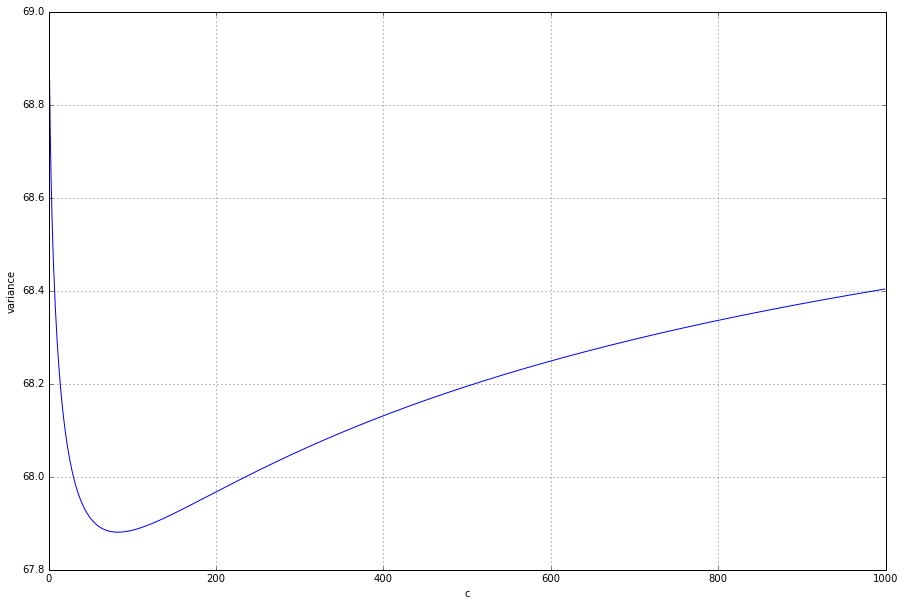

In [142]:
%matplotlib inline
grid = np.arange(1000)
plt.figure(figsize=(15,10))
plt.plot(grid, [var(i) for i in grid], linewidth=1)
plt.xlabel('c')
plt.ylabel('variance')
plt.grid()
plt.show()

Вау) есть минимум! Посмотрим поближе...

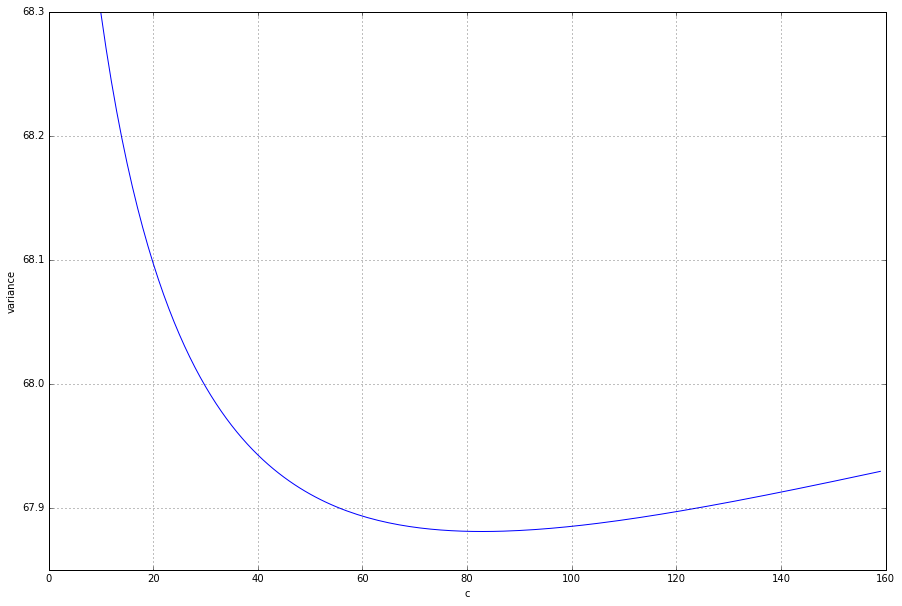

In [143]:
grid = np.arange(10, 160)
plt.figure(figsize=(15,10))
plt.plot(grid, [var(i) for i in grid], linewidth=1)
plt.xlabel('c')
plt.ylabel('variance')
plt.grid()
plt.show()

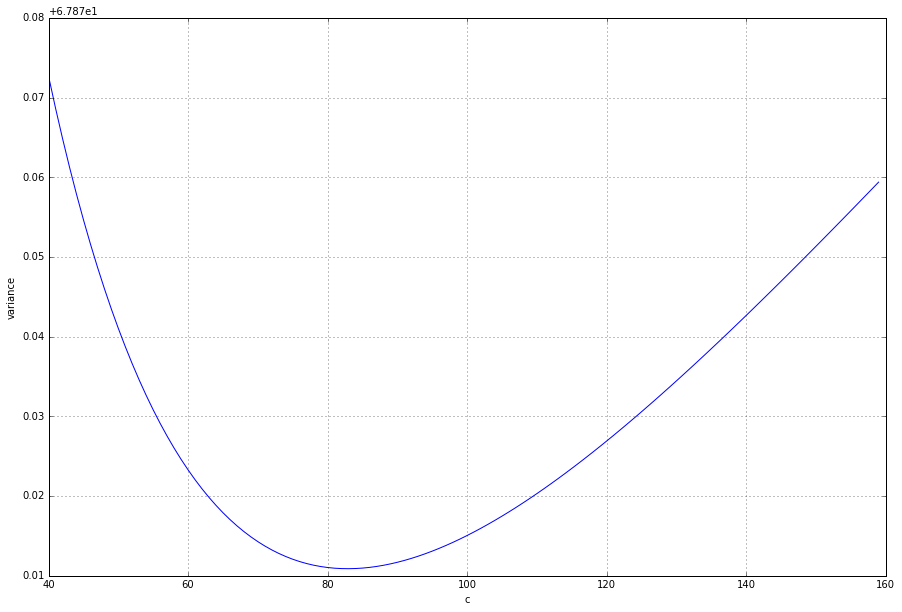

In [144]:
grid = np.arange(40, 160)
plt.figure(figsize=(15,10))
plt.plot(grid, [var(i) for i in grid], linewidth=1)
plt.xlabel('c')
plt.ylabel('variance')
plt.grid()
plt.show()

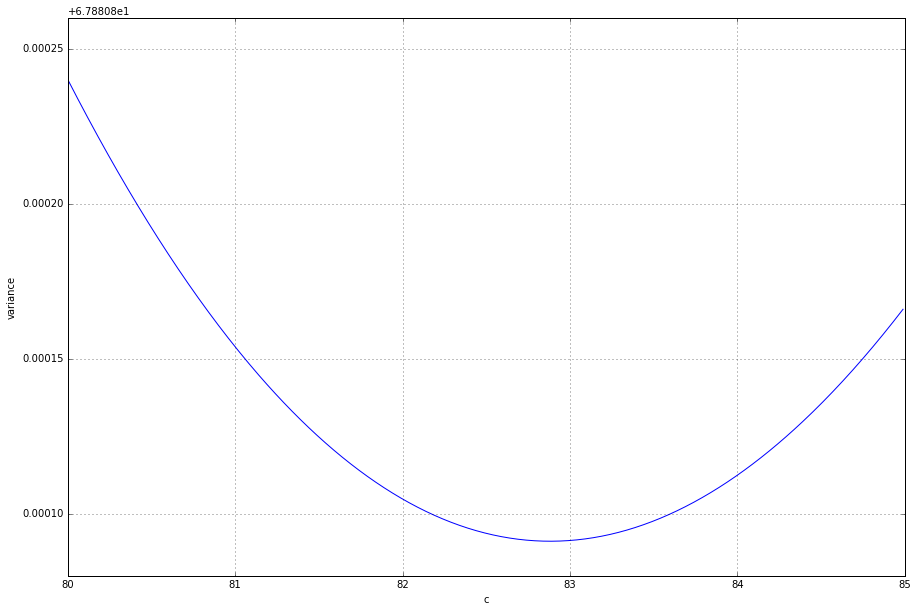

In [145]:
grid = np.arange(80, 85, 0.01)
plt.figure(figsize=(15,10))
plt.plot(grid, [var(i) for i in grid], linewidth=1)
plt.xlabel('c')
plt.ylabel('variance')
plt.grid()
plt.show()

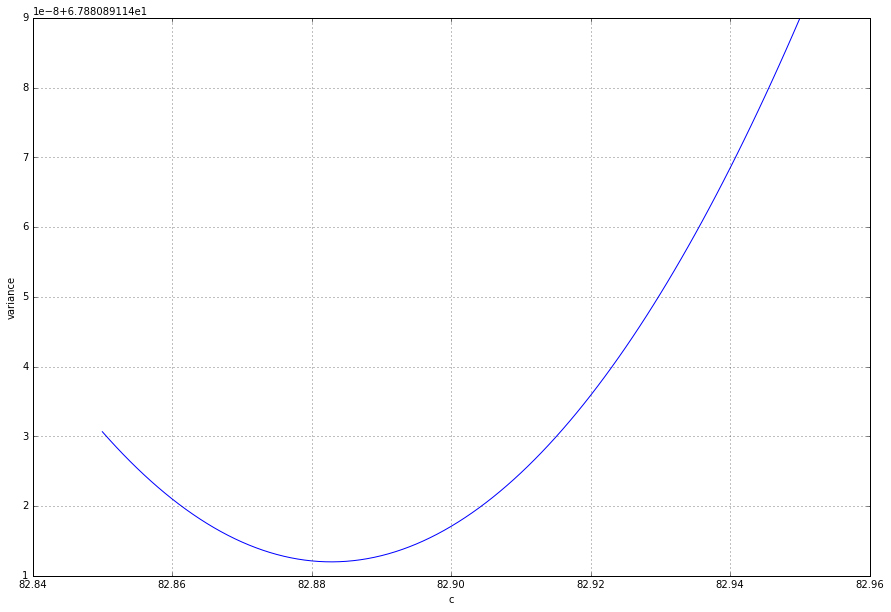

In [146]:
grid = np.arange(82.85, 82.95, 0.001)
plt.figure(figsize=(15,10))
plt.plot(grid, [var(i) for i in grid], linewidth=1)
plt.xlabel('c')
plt.ylabel('variance')
plt.grid()
plt.show()

Минимум где-то между 82.88 и 82.90. Найдем его поточнее

In [127]:
opt=optimize.minimize(var, 82.89, method='Nelder-Mead')
print(opt)

 final_simplex: (array([[ 82.88285387],
       [ 82.88279063]]), array([ 67.88089115,  67.88089115]))
           fun: 67.880891152007919
       message: 'Optimization terminated successfully.'
          nfev: 34
           nit: 17
        status: 0
       success: True
             x: array([ 82.88285387])


###### Итак, минимум достигается при c = 82.88285387, минимальное отклонение - 67.88
Выигрыш незначительный
Исследую зависимость от разбиения

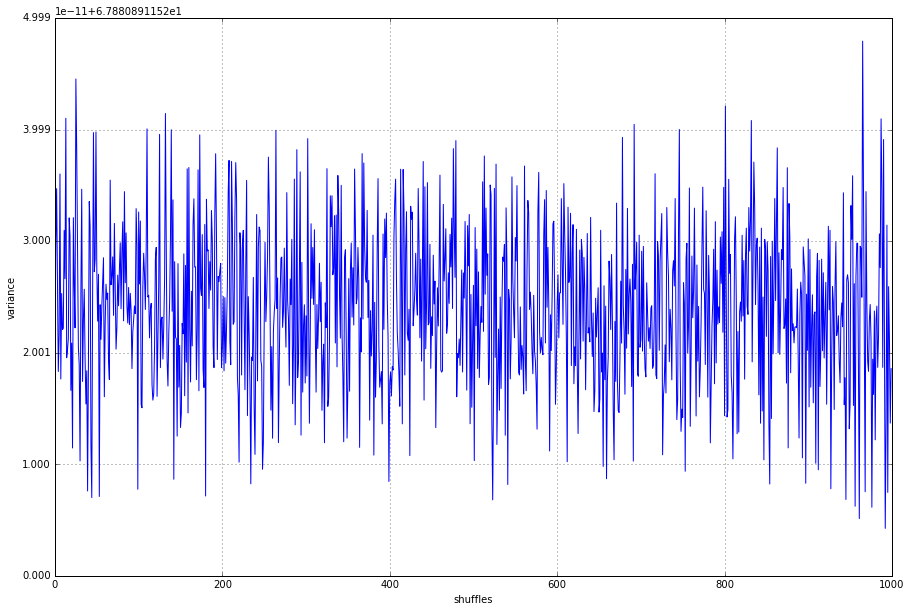

In [131]:
grid = np.arange(1000)

results = list()
for i in grid:
    dataset = dataset.reindex(np.random.permutation(dataset.index))
    set1 = dataset.drop(np.arange(n, dataset.shape[0]))
    set2 = dataset.drop(np.arange(n))
    results.append(var(opt.x))

plt.figure(figsize=(15,10))
plt.plot(grid, results, linewidth=1)
plt.xlabel('shuffles')
plt.ylabel('variance')
plt.grid()
plt.show()

На графике видно, что отклонение хоть и зависит от разбиения, но очень незначительно (разброс порядка 10^(-11))